In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D
import netCDF4
import numpy
import os
import pandas
from PIL import Image
import random
import readline
import scipy
from scipy import fft
from scipy import linalg
from scipy import stats
from scipy.stats import poisson, ttest_ind
import seaborn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import normalize
from statsmodels.tsa.ar_model import AutoReg
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/Output_Files/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_Output_V3.csv')
    ET_DF = Open_File(Diri+Model+'_ET_Output_V3.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V3.csv')
    Time = []
    Start_Time = []
    End_Time = []
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Start_Time.append(Datetime(ET_DF["Start Time"][j]))
        End_Time.append(Datetime(ET_DF["End Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["Start Time"] = Start_Time
    ET_DF["End Time"] = End_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    return (New_Time)

In [6]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [7]:
#Control_Data[265:277]

In [8]:
#Control_ET[5:8]

In [9]:
#Control_Codes[5:8]

In [10]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)

In [11]:
# Find a Specific Storm Within the DataFrame
def Find_Storm(DF, Code):
    DF_Storm = DF[DF["Code"] == Code].reset_index()
    return (DF_Storm)

In [12]:
Month_Days = numpy.zeros(13)
for m in range(13):
    if m < 12:
        Days = datetime.date(2023,m+1,1) - datetime.date(2023,1,1)
        Month_Days[m] = int(Days.days)
    else:
        Month_Days[m] = 365
Months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan"]
Day_Vals = Create_Bins(0,365,5)

In [13]:
# Function For Calculating How Many Days Since January 1st
def Date_Days(ET_DF):
    ET_Days = ET_DF.copy()
    Start_Time = ET_Days["Start Time"]
    Days_Array = numpy.zeros(len(Start_Time))
    for i in range(len(Start_Time)):
        Time = Start_Time[i].date()
        Year = Time.year
        NYD = datetime.date(Year,1,1)
        Days = Time - NYD
        Days_Array[i] = Days.days
    ET_Days["Days"] = Days_Array
    return (ET_Days)
Control_ET_Days = Date_Days(Control_ET)
RCP45_ET_Days = Date_Days(RCP45_ET)
RCP85_ET_Days = Date_Days(RCP85_ET)

In [14]:
# Function For Creating Cumulative Distribution
def Cum_Dist(Array, Var):
    Array = Array[Array > -728]
    if Var == "Start Lat" or Var == "End Lat" or Var == "Days":
        Sorted = numpy.sort(Array)
    else:
        Sorted = numpy.sort(Array)[::-1]
    Len = len(Sorted)
#
# Apply Smoothing
    if Var == "Days":
        Sorted_Smooth = Smoothing_Time(Sorted, Len)
    else:
        if Var == "Start Lat" or Var == "End Lat":
            Param = 2.5
        elif Var == "ET Dist":
            Param = 250
        else:
            Param = 5
        Sorted_Smooth = Smoothing(Sorted, Len, Param)
    Density = numpy.arange(0,1.0001,1/(Len-1))
    return (Sorted_Smooth, Density)

In [15]:
# Function For Cumulative Dist Smoothing
def Smoothing(Sorted, Len, Param):
    F = Len-1
    for i in range(Len):
        if i == 1 or i == (F-1):
            Outside_Diff = Sorted[i+1] - Sorted[i-1]
            Sorted[i] = 0.5 * (Sorted[i-1] + Outside_Diff / 2) + 0.5 * (Sorted[i+1] - Outside_Diff / 2)
        elif i == 2 or i == (F-2):
            Outside_Diff = Sorted[i+2] - Sorted[i-2]
            Sorted[i] = 0.5 * (Sorted[i-1] + Outside_Diff / 4) + 0.5 * (Sorted[i+1] - Outside_Diff / 4)
        elif i > 2 and i < (F-2):
            Outside_Diff = Sorted[i+3] - Sorted[i-3]
            Sorted[i] = 0.5 * (Sorted[i-1] + Outside_Diff / 6) + 0.5 * (Sorted[i+1] - Outside_Diff / 6)
    return (Sorted)

In [16]:
# Function For Cumulative Dist Smoothing For Date
def Smoothing_Time(Sorted, Len):
    for i in range(Len):
        if i > 0 and i < Len-1:
            Orig_Val = Sorted[i]
            if i == 1:
                Outside_Diff = Sorted[i+4] + (Sorted[Len-1] - Sorted[Len-4])
            elif i == 2:
                Outside_Diff = Sorted[i+4] + (Sorted[Len-1] - Sorted[Len-3])
            elif i == 3:
                Outside_Diff = Sorted[i+4] + (Sorted[Len-1] - Sorted[Len-2])
            elif i == Len-4:
                Outside_Diff = Sorted[1] + (Sorted[Len-1] - Sorted[i-4])
            elif i == Len-3:
                Outside_Diff = Sorted[2] + (Sorted[Len-1] - Sorted[i-4])
            elif i == Len-2:
                Outside_Diff = Sorted[3] + (Sorted[Len-1] - Sorted[i-4])
            else:
                Outside_Diff = Sorted[i+4] - Sorted[i-4]
            Sorted[i] = (0.2 * Orig_Val) + (0.4 * (Sorted[i-1] + Outside_Diff / 8)) + \
            (0.4 * (Sorted[i+1] - Outside_Diff / 8))
    return (Sorted)

In [17]:
# Function to Plot Probability Distribution Functions
def Prob_Dist(DF, Var):
    Cum_Sorted, Cum_Density = Cum_Dist(DF[Var], Var)
    Len = len(Cum_Sorted)
#
# Regular Variables
    if Var != "Days":
        if Var == "Start Lat" or Var == "End Lat":
            Param = 2.5
            Width = 1
        else:
            Param = 5
            Width = -1
        Start_Val = (int(Cum_Sorted[0] / Width - 0.01)) * Width
        End_Val = (int(Cum_Sorted[Len-1] / Width + 1.01)) * Width
        Range = int((End_Val - Start_Val) / Width)
        Prob_Vals = numpy.arange(Start_Val, End_Val+Width, Width)
        Prob_Count_0 = numpy.zeros(Range+1)
        for k in range(Range):
            if k == 0:
                Vals_Range = []
            elif k == Len-1:
                Vals_Range = []
            else:
                Vals_Range = Cum_Sorted[(Cum_Sorted >= Prob_Vals[k]-numpy.abs(Param)) & \
                (Cum_Sorted < Prob_Vals[k]+numpy.abs(Param))]
            Prob_Count_0[k] = len(Vals_Range) / (2 * Param)
        Prob_Count_1 = Smoothing_Prob(Prob_Count_0)
        Prob_Count_2 = Smoothing_Prob(Prob_Count_1)
        Prob_Density = Prob_Count_2 / Len
#
# Time
    else:
        Start_Val = 0
        End_Val = 365
        Width = 5
        Param = 15
        Range = int((End_Val - Start_Val) / Width)
        Prob_Vals = numpy.arange(Start_Val, End_Val+Width, Width)
        Prob_Count_0 = numpy.zeros(Range+1)
        for k in range(Range+1):
            if k <= 3 or k >= Range-2:
                if k == 0:
                    Vals_Range_1 = Cum_Sorted[(Cum_Sorted < Prob_Vals[k] + 15)]
                    Vals_Range_2 = Cum_Sorted[(Cum_Sorted >= End_Val - 15)]
                elif k == 1:
                    Vals_Range_1 = Cum_Sorted[(Cum_Sorted < Prob_Vals[k] + 20)]
                    Vals_Range_2 = Cum_Sorted[(Cum_Sorted >= End_Val - 10)]
                elif k == 2:
                    Vals_Range_1 = Cum_Sorted[(Cum_Sorted < Prob_Vals[k] + 25)]
                    Vals_Range_2 = Cum_Sorted[(Cum_Sorted >= End_Val - 5)]
                elif k == Range-2:
                    Vals_Range_1 = Cum_Sorted[(Cum_Sorted < Start_Val + 5)]
                    Vals_Range_2 = Cum_Sorted[(Cum_Sorted >= Prob_Vals[k] - 25)]
                elif k == Range-1:
                    Vals_Range_1 = Cum_Sorted[(Cum_Sorted < Start_Val + 10)]
                    Vals_Range_2 = Cum_Sorted[(Cum_Sorted >= Prob_Vals[k] - 20)]
                elif k == Range:
                    Vals_Range_1 = Cum_Sorted[(Cum_Sorted < Start_Val + 15)]
                    Vals_Range_2 = Cum_Sorted[(Cum_Sorted >= Prob_Vals[k] - 15)]
                Count = len(Vals_Range_1) + len(Vals_Range_2)
            else:
                Vals_Range = Cum_Sorted[(Cum_Sorted >= Prob_Vals[k]-Param) & \
                (Cum_Sorted < Prob_Vals[k]+Param)]
                Count = len(Vals_Range)
            Prob_Count_0[k] = Count / (2 * Param)
# Apply Smoothing Twice
        Prob_Count_1 = Smoothing_Prob_Time(Prob_Count_0)
        Prob_Count_2 = Smoothing_Prob_Time(Prob_Count_1)
        Prob_Density = Prob_Count_2 / Len
    return (Prob_Vals, Prob_Density)

In [18]:
# Function For Cumulative Dist Smoothing
def Smoothing_Prob(Count):
    Count_Len = len(Count)
    F = Count_Len-1
    for i in range(Count_Len):
        if i == 1 or i == (F-1):
            Outside_Diff = Count[i+1] - Count[i-1]
            Count[i] = 0.5 * (Count[i-1] + Outside_Diff / 2) + 0.5 * (Count[i+1] - Outside_Diff / 2)
        elif i == 2 or i == (F-2):
            Outside_Diff = Count[i+2] - Count[i-2]
            Count[i] = 0.5 * (Count[i-1] + Outside_Diff / 4) + 0.5 * (Count[i+1] - Outside_Diff / 4)
        elif i > 2 and i < (F-2):
            Outside_Diff = Count[i+3] - Count[i-3]
            Count[i] = 0.5 * (Count[i-1] + Outside_Diff / 6) + 0.5 * (Count[i+1] - Outside_Diff / 6)
    return (Count)

In [19]:
# Function For Probability Distribution Smoothing
def Smoothing_Prob_Time(Count):
    Count_Len = len(Count)
    F = Count_Len-1
# Smoothing Based on Data Points k+3 and k-3
    for k in range(Count_Len):
        if k > 0 and k < F:
            Orig_Val = Count[k]
            if k == 1:
                Outside_Diff = Count[k+3] + (Count[F] - Count[F-2])
            elif k == 2:
                Outside_Diff = Count[k+3] + (Count[F] - Count[F-1])
            elif k == F-2:
                Outside_Diff = Count[1] + (Count[F] - Count[k-3])
            elif k == F-1:
                Outside_Diff = Count[2] + (Count[F] - Count[k-3])
            else:
                Outside_Diff = Count[k+3] - Count[k-3]
# Use 50% of the Original Value, 25% of Smoothing From i-1 and 25% of Smoothing From i+1
            Count[k] = (0.5 * Orig_Val) + (0.25 * (Count[k-1] + Outside_Diff / 6)) + \
            (0.25 * (Count[k+1] - Outside_Diff / 6))
        elif k == F:
            Orig_Val = Count[k]
            Outside_Diff = Count[3] + (Count[F] - Count[F-3])
            Count[k] = (0.5 * Orig_Val) + (0.25 * (Count[F-1] + Outside_Diff / 6)) + \
            (0.25 * (Count[1] - Outside_Diff / 6))
# First and Last Value Both Represent January 1st, Must be Same
            Count[0] = Count[k]
    return (Count)

In [20]:
# Formatting Based on Variable
def Cum_Dist_Formatting(Vals_1, Vals_2, Vals_3, Var):
# x Ticks and Lims
    if Var == "Start Lat" or Var == "End Lat":
        Min = 0
        Max = 60
        Width = 5
    elif Var == "Start Lon" or Var == "End Lon":
        Min = -100
        Max = 10
        Width = 10
    elif Var == "Start SLP" or Var == "End SLP":
        Min = 900
        Max = 1020
        Width = 10
    elif Var == "Days":
        Min = 0
        Max = 0.009
        Width = 0.001
    x_Ticks = Create_Bins(Min, Max, Width)
#
# y Ticks and Lims
    if Var == "Start Lat" or Var == "End Lat":
        pyplot.yticks(x_Ticks)
        pyplot.ylim(Min, Max)
        pyplot.xticks(Create_Bins(0,1,0.125))
        pyplot.xlim(0,1)
    elif Var == "Days":
        pyplot.xticks(Month_Days, Months)
        pyplot.xlim(-1,366)
        pyplot.yticks(Create_Bins(0,1,0.125))
        pyplot.ylim(0,1)
    else:
        pyplot.xticks(x_Ticks)
        pyplot.xlim(Min, Max)
        pyplot.yticks(Create_Bins(0,1,0.125))
        pyplot.ylim(0,1)
#
# Labels and Title
    if Var == "Start Lat" or Var == "End Lat":
        pyplot.xlabel("Cumulative Frequency Density", fontsize=18)
        pyplot.ylabel("Latitude", fontsize=18)
        Title = Var + "itude of ET Transition"
    else:
        pyplot.ylabel("Cumulative Frequency Density", fontsize=18)
        if Var == "Start Lon" or Var == "End Lon":
            pyplot.xlabel("Longitude", fontsize=18)
            Title = Var + "gitude of ET Transition"
        elif Var == "Start SLP" or Var == "End SLP":
            pyplot.xlabel("Sea Level Pressure (SLP)", fontsize=18)
            Title = Var + " of ET Transition"
        elif Var == "Days":
            pyplot.xlabel("Month", fontsize=18)
            Title = "Date of Initiation of ET Transition"
    pyplot.title(Title, fontsize=25)
#
# Legend
    if Var == "Days":
        pyplot.legend(loc=4, fontsize=15)
    else:
        pyplot.legend(loc=3, fontsize=15)

In [21]:
# Create Function to Plot ET Cumulative Distributions
def ET_Cum_Dist_Plot(Fig, ET_DF_1, ET_DF_2, ET_DF_3, Var):
    if Var == "Start Lat" or Var == "Start Lon" or Var == "Start SLP":
        Axis = Fig.add_subplot(1,2,1)
    elif Var == "End Lat" or Var == "End Lon" or Var == "End SLP":
        Axis = Fig.add_subplot(1,2,2)
    else:
        Axis = Fig.add_subplot(1,1,1)
#
# Apply Cumulative Distribution Function
    Sorted_1, Density_1 = Cum_Dist(ET_DF_1[Var], Var)
    Sorted_2, Density_2 = Cum_Dist(ET_DF_2[Var], Var)
    Sorted_3, Density_3 = Cum_Dist(ET_DF_3[Var], Var)
#
# Plotting
    if Var == "Start Lat" or Var == "End Lat":
        Axis.plot(Density_1, Sorted_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(Density_2, Sorted_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(Density_3, Sorted_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
    else:
        Axis.plot(Sorted_1, Density_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(Sorted_2, Density_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(Sorted_3, Density_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
#
# Formatting Based on Variable
    Cum_Dist_Formatting(Sorted_1, Sorted_2, Sorted_3, Var)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

In [22]:
# Formatting Based on Variable
def Prob_Dist_Formatting(Vals_1, Vals_2, Vals_3, Dens_1, Dens_2, Dens_3, Var):
# x Ticks and Lims
    if Var != "Days":
        if Var == "Start Lat" or Var == "End Lat":
            Min = 0
            Max = 60
            Width = 5
        elif Var == "Start Lon" or Var == "End Lon":
            Min = -100
            Max = 10
            Width = 10
        elif Var == "Start SLP" or Var == "End SLP":
            Min = 900
            Max = 1020
            Width = 10
        x_Ticks = Create_Bins(Min, Max, Width)
#
# y Ticks and Lims
    Max_Dens = numpy.max([numpy.max(Dens_1), numpy.max(Dens_2), numpy.max(Dens_3)])
    if Max_Dens <= 0.003:
        y_Width = 0.0002
    elif Max_Dens <= 0.006:
        y_Width = 0.0005
    elif Max_Dens <= 0.012:
        y_Width = 0.001
    elif Max_Dens <= 0.025:
        y_Width = 0.002
    elif Max_Dens <= 0.06:
        y_Width = 0.005
    elif Max_Dens <= 0.12:
        y_Width = 0.01
    elif Max_Dens <= 0.25:
        y_Width = 0.02
    else:
        y_Width = 0.05
    y_Max = (int(Max_Dens / y_Width) + 1) * y_Width
    y_Ticks = Create_Bins(0, y_Max, y_Width)
#
    if Var == "Start Lat" or Var == "End Lat":
        pyplot.yticks(x_Ticks)
        pyplot.ylim(Min, Max)
        pyplot.xticks(y_Ticks)
        pyplot.xlim(0, y_Max)
    else:
        pyplot.yticks(y_Ticks)
        pyplot.ylim(0, y_Max)
        if Var == "Days":
            pyplot.xticks(Month_Days, Months)
            pyplot.xlim(-1,366)
        else:
            pyplot.xticks(x_Ticks)
            pyplot.xlim(Min, Max)
#
# Labels and Title
    if Var == "Start Lat" or Var == "End Lat":
        pyplot.xlabel("Probability Frequency Density", fontsize=18)
        pyplot.ylabel("Latitude", fontsize=18)
        Title = Var + "itude of ET Transition"
    else:
        pyplot.ylabel("Probability Frequency Density", fontsize=18)
        if Var == "Start Lon" or Var == "End Lon":
            pyplot.xlabel("Longitude", fontsize=18)
            Title = Var + "gitude of ET Transition"
        elif Var == "Start SLP" or Var == "End SLP":
            pyplot.xlabel("Sea Level Pressure (SLP)", fontsize=18)
            Title = Var + " of ET Transition"
        elif Var == "Days":
            pyplot.xlabel("Month", fontsize=18)
            Title = "Date of Initiation of ET Transition"
    pyplot.title(Title, fontsize=25)
#
# Legend
    if Var == "Start SLP" or Var == "End SLP" or Var == "Start Time":
        pyplot.legend(loc=2, fontsize=15)
    else:
        pyplot.legend(loc=1, fontsize=15)

In [23]:
# Create Function to Plot ET Probability Distributions
def ET_Prob_Dist_Plot(Fig, ET_DF_1, ET_DF_2, ET_DF_3, Var):
    if Var == "Start Lat" or Var == "Start Lon" or Var == "Start SLP":
        Axis = Fig.add_subplot(1,2,1)
    elif Var == "End Lat" or Var == "End Lon" or Var == "End SLP":
        Axis = Fig.add_subplot(1,2,2)
    else:
        Axis = Fig.add_subplot(1,1,1)
#
# Apply Probability Distribution Function
    Values_1, Density_1 = Prob_Dist(ET_DF_1, Var)
    Values_2, Density_2 = Prob_Dist(ET_DF_2, Var)
    Values_3, Density_3 = Prob_Dist(ET_DF_3, Var)
#
# Plotting
    if Var == "Start Lat" or Var == "End Lat":
        Axis.plot(Density_1, Values_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(Density_2, Values_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(Density_3, Values_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
    else:
        Axis.plot(Values_1, Density_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(Values_2, Density_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(Values_3, Density_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
##
# Formatting Based on Variable
    Prob_Dist_Formatting(Values_1, Values_2, Values_3, Density_1, Density_2, Density_3, Var)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

In [24]:
# Plot Cumulative Density Functions and Probability Density Functions

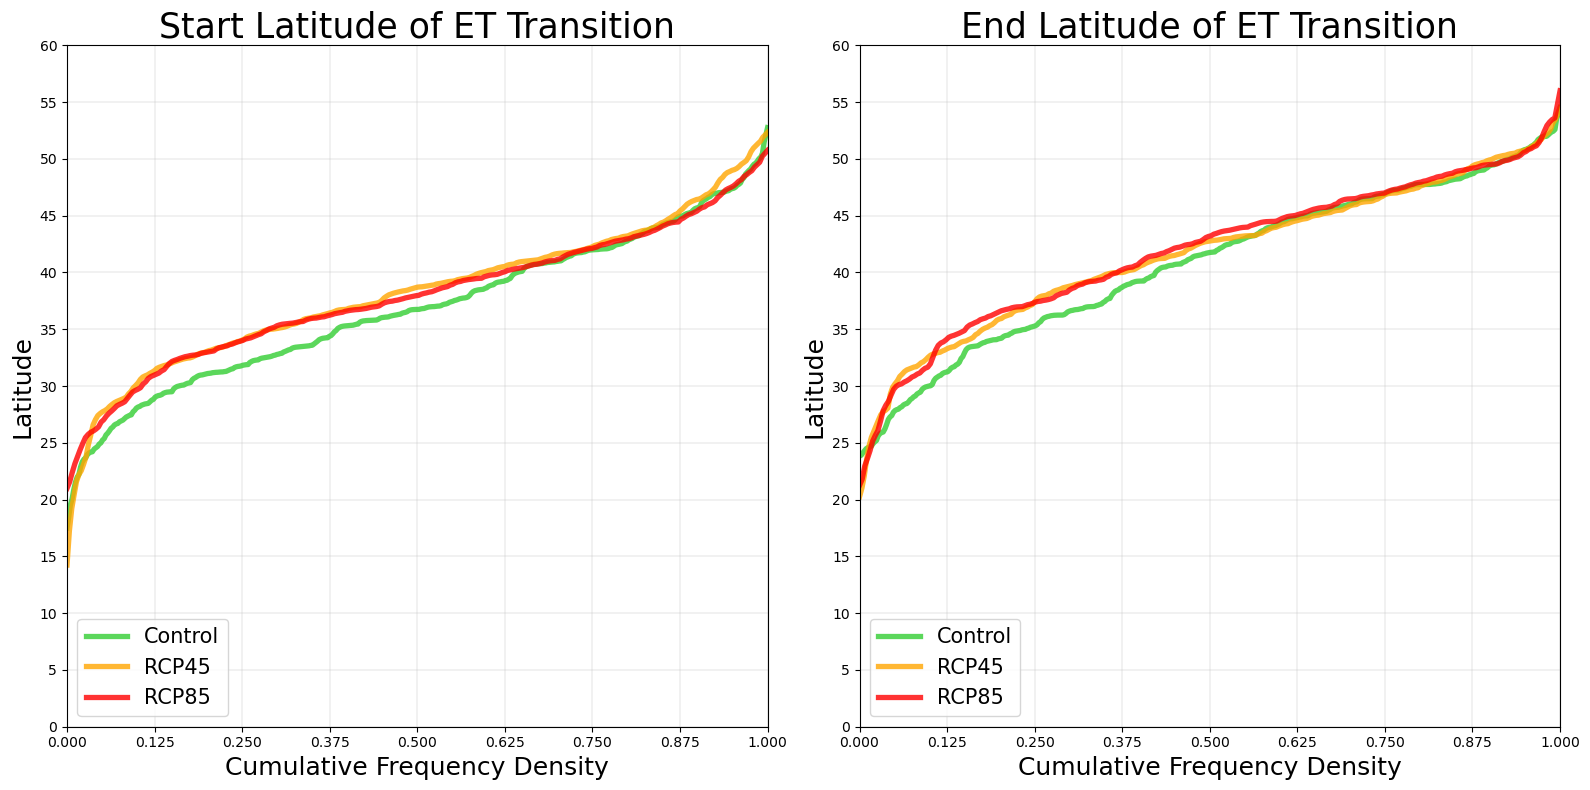

In [25]:
# Start Lat and End Lat
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Start Lat")
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "End Lat")
pyplot.tight_layout()
Figname = str('ET_Latitude_Cumulative.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

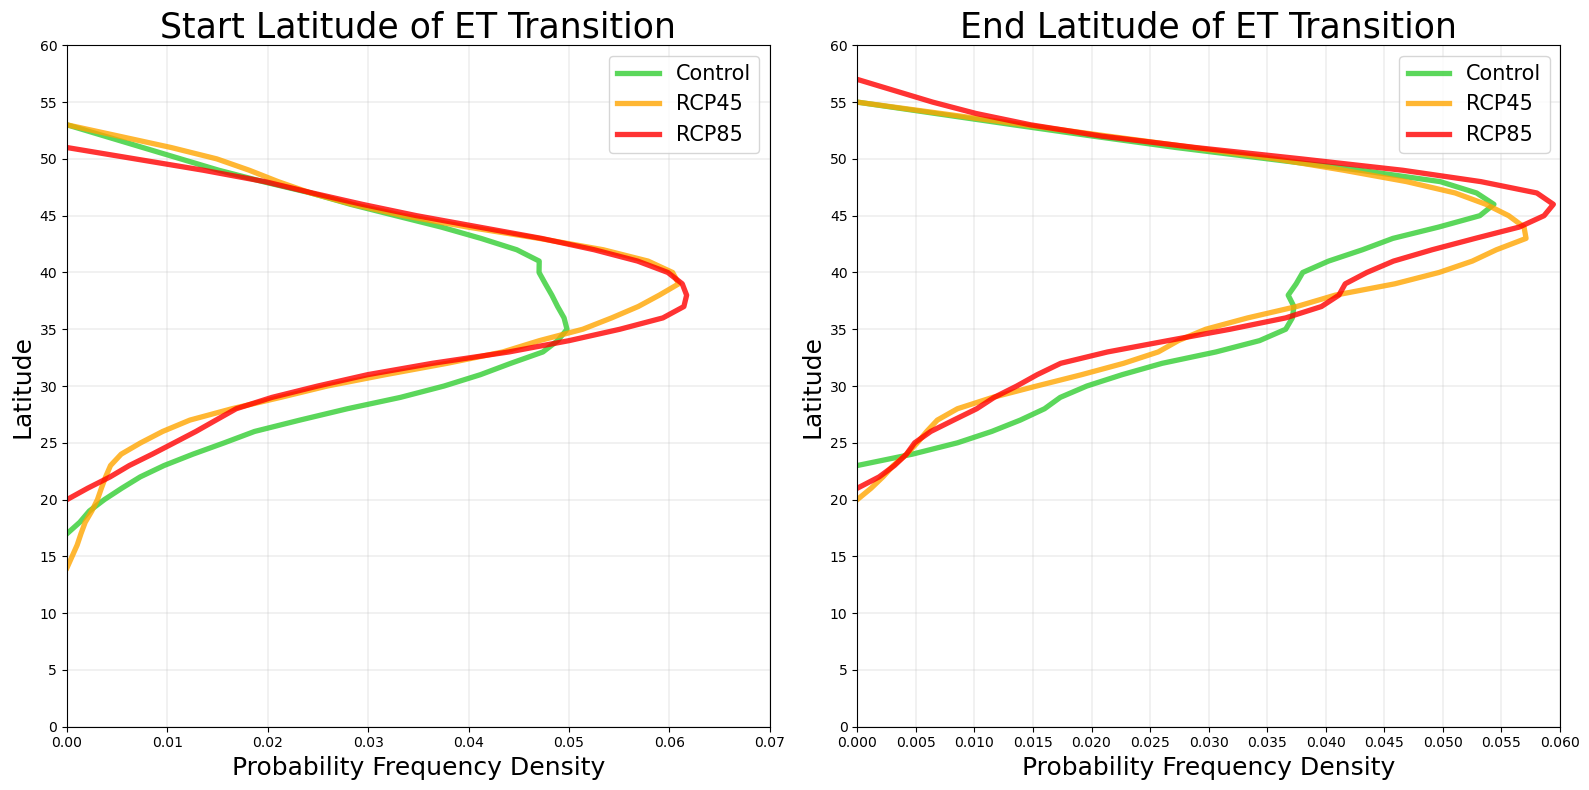

In [26]:
# Start Lat and End Lat
Fig = pyplot.figure(figsize=(16,8))
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Start Lat")
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "End Lat")
pyplot.tight_layout()
Figname = str('ET_Latitude_Prob.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

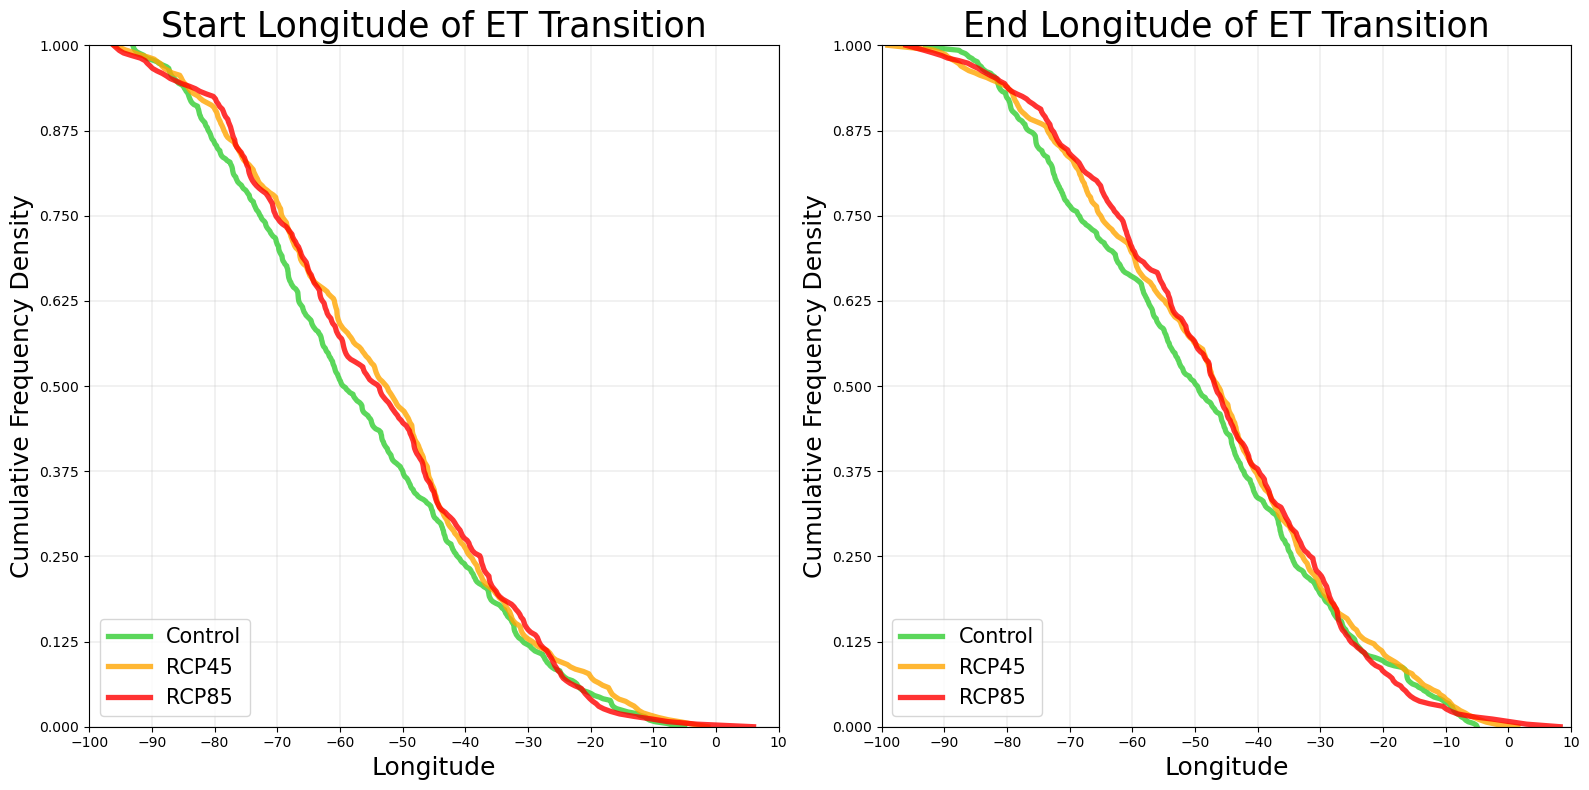

In [27]:
# Start Lon and End Lon
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Start Lon")
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "End Lon")
pyplot.tight_layout()
Figname = str('ET_Longitude_Cumulative.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

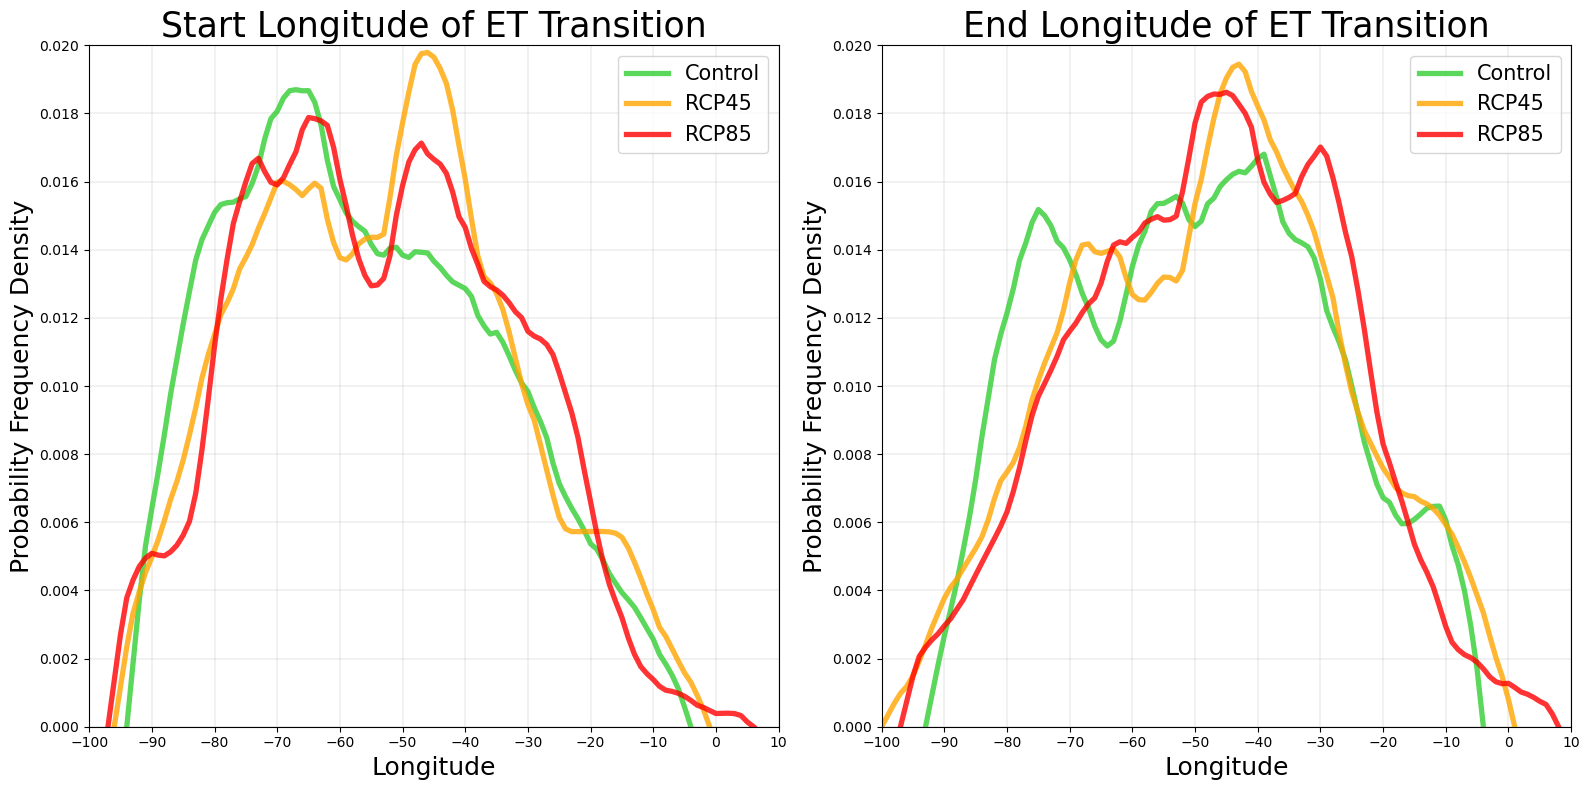

In [28]:
# Start Lon and End Lon
Fig = pyplot.figure(figsize=(16,8))
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Start Lon")
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "End Lon")
pyplot.tight_layout()
Figname = str('ET_Longitude_Prob.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

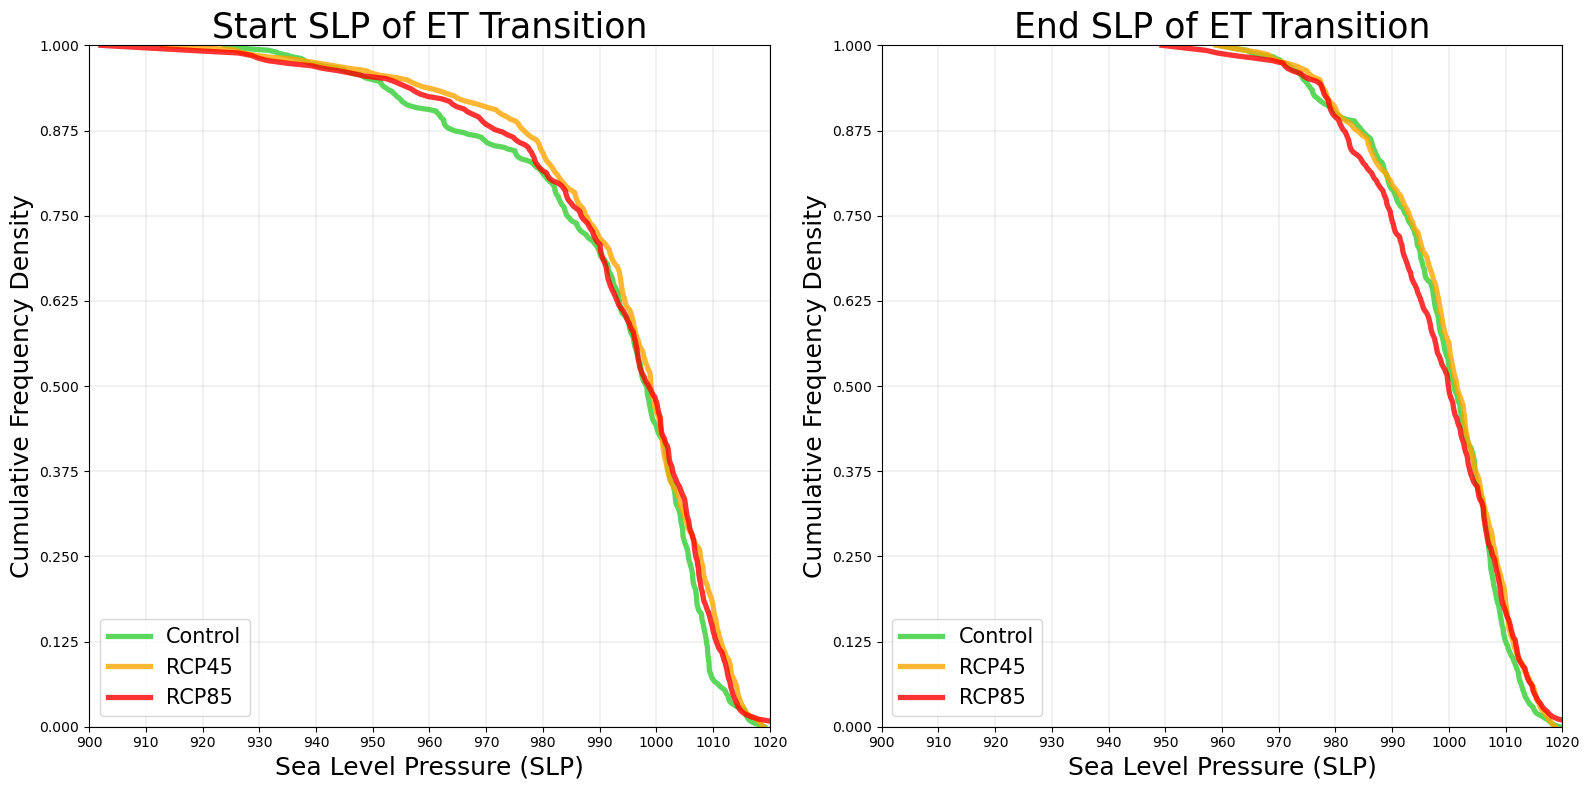

In [29]:
# Start SLP and End SLP
Fig = pyplot.figure(figsize=(16,8))
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Start SLP")
ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "End SLP")
pyplot.tight_layout()
Figname = str('ET_SLP_Cumulative.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

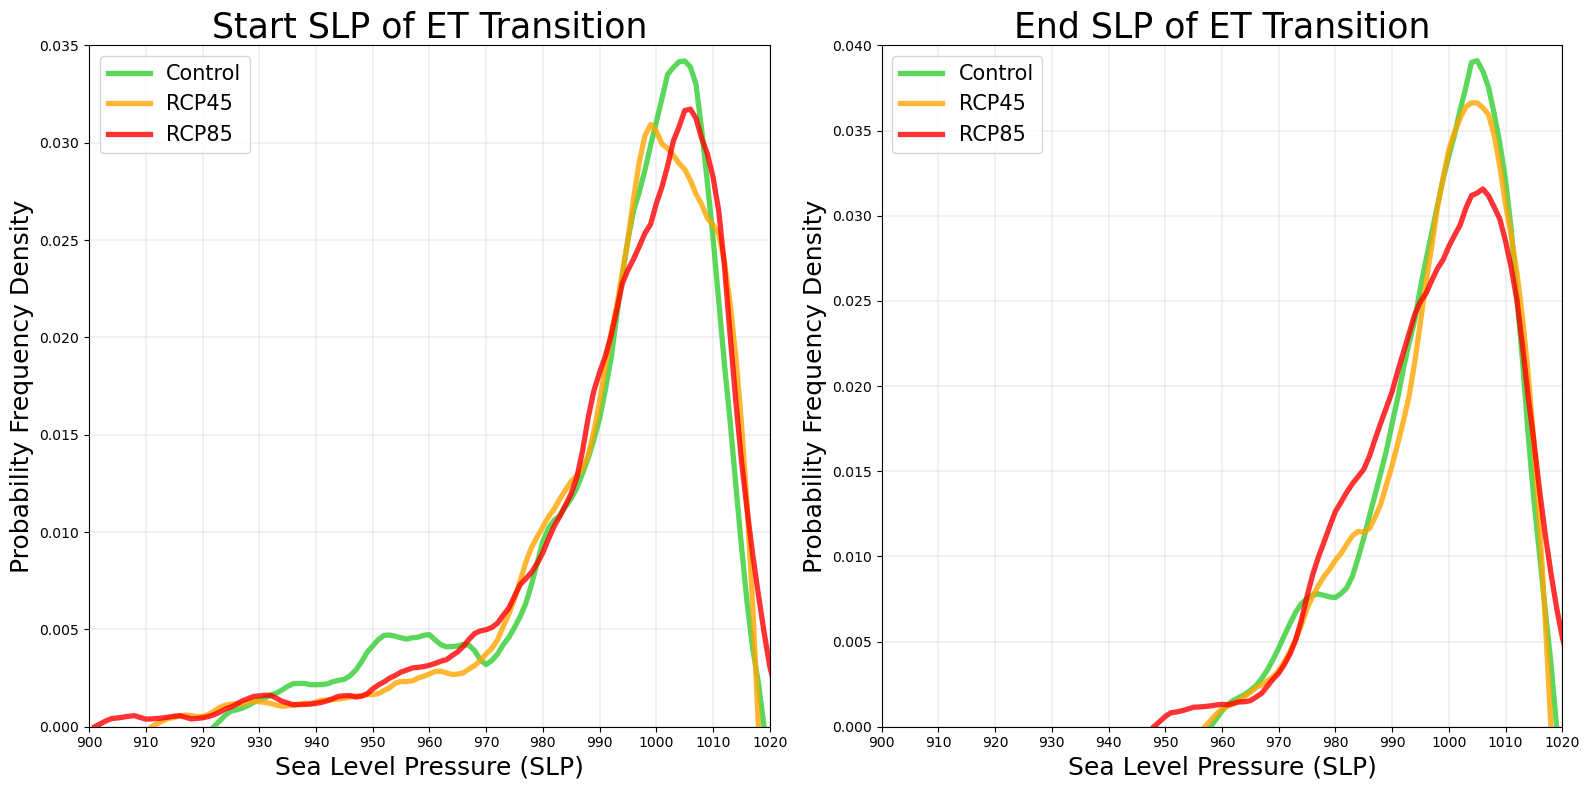

In [30]:
# Start SLP and End SLP
Fig = pyplot.figure(figsize=(16,8))
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Start SLP")
ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "End SLP")
pyplot.tight_layout()
Figname = str('ET_SLP_Prob.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

In [31]:
# ET Duration and Date
#Fig = pyplot.figure(figsize=(16,8))
#ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "ET Duration (hr)")
#ET_Cum_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Start Time")
#pyplot.tight_layout()
#Figname = str('ET_Durations_Cumulative.png')
#Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

In [32]:
# ET Duration and Date
#Fig = pyplot.figure(figsize=(16,8))
#ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "ET Duration (hr)")
#ET_Prob_Dist_Plot(Fig, Control_ET, RCP45_ET, RCP85_ET, "Start Time")
#pyplot.tight_layout()
#Figname = str('ET_Durations_Prob.png')
#Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')

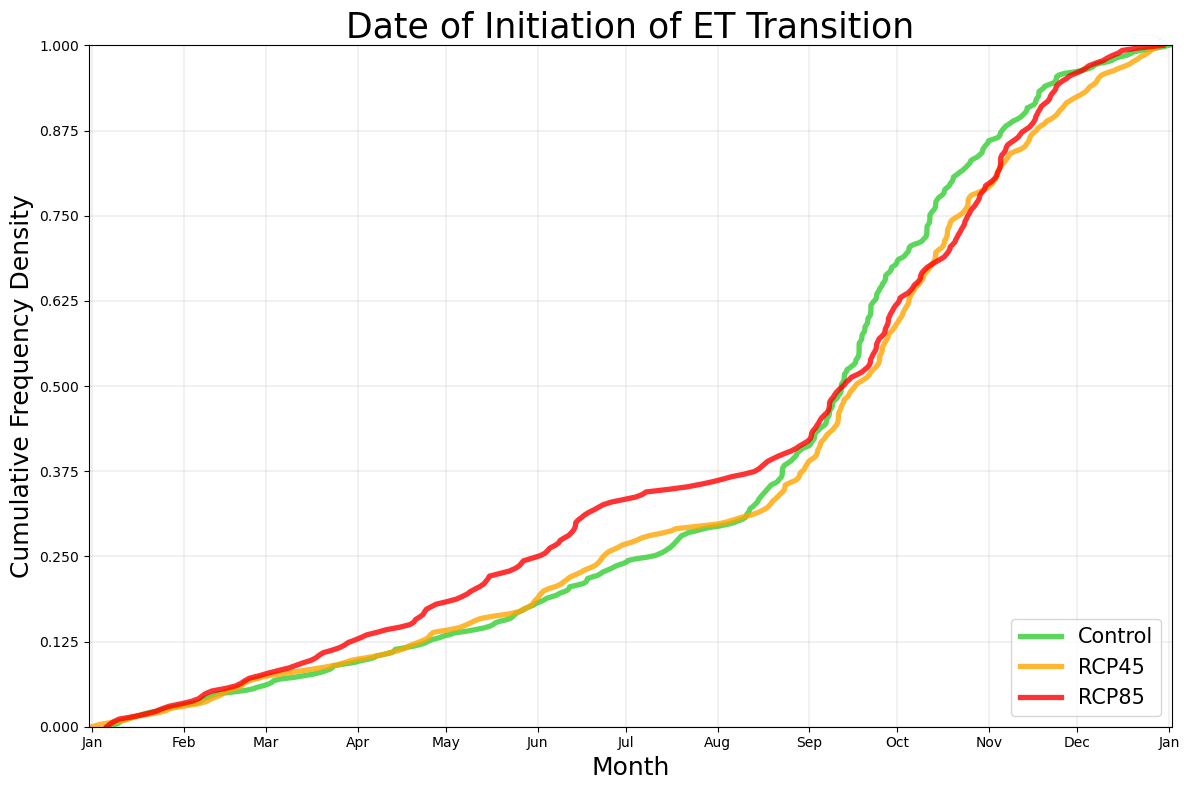

In [33]:
# ET Date
Fig = pyplot.figure(figsize=(12,8))
ET_Cum_Dist_Plot(Fig, Control_ET_Days, RCP45_ET_Days, RCP85_ET_Days, "Days")
Figname = str('ET_Date_Cumulative.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')
pyplot.tight_layout()

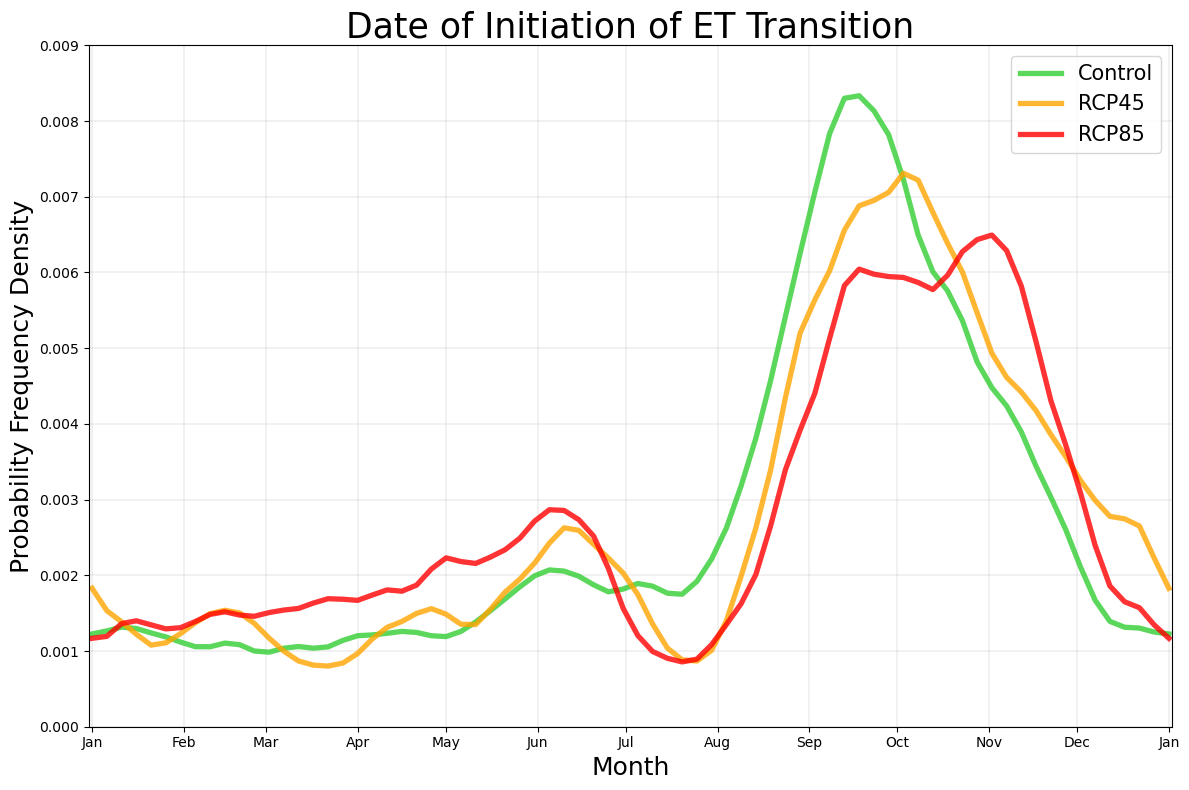

In [34]:
# ET Date
Fig = pyplot.figure(figsize=(12,8))
ET_Prob_Dist_Plot(Fig, Control_ET_Days, RCP45_ET_Days, RCP85_ET_Days, "Days")
Figname = str('ET_Date_Prob.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V3/'+Figname, bbox_inches='tight')
pyplot.tight_layout()

In [35]:
# Function For Creating Cumulative Distribution With No Smoothing
def Cum_Dist_Raw(Array, Var):
    Array = Array[Array > -728]
    if Var == "Start Lat" or Var == "End Lat" or Var == "Days":
        Sorted = numpy.sort(Array)
    else:
        Sorted = numpy.sort(Array)[::-1]
    Len = len(Sorted)
    Density = numpy.arange(0,1.0001,1/(Len-1))
    return (Sorted, Density)

In [36]:
# Function to Plot Probability Distribution Functions With No Smoothing
def Prob_Dist_Raw(DF, Var):
    Cum_Sorted, Cum_Density = Cum_Dist_Raw(DF[Var], Var)
    Len = len(Cum_Sorted)
#
# Regular Variables
    if Var != "Days":
        if Var == "Start Lat" or Var == "End Lat":
            Param = 2.5
            Width = 1
        else:
            Param = 5
            Width = -1
        Start_Val = (int(Cum_Sorted[0] / Width - 0.01)) * Width
        End_Val = (int(Cum_Sorted[Len-1] / Width + 1.01)) * Width
        Range = int((End_Val - Start_Val) / Width)
        Prob_Vals = numpy.arange(Start_Val, End_Val+Width, Width)
        Prob_Count = numpy.zeros(Range+1)
        for k in range(Range):
            if k == 0:
                Vals_Range = []
            elif k == Len-1:
                Vals_Range = []
            else:
                Vals_Range = Cum_Sorted[(Cum_Sorted >= Prob_Vals[k]-numpy.abs(Param)) & \
                (Cum_Sorted < Prob_Vals[k]+numpy.abs(Param))]
            Prob_Count_0[k] = len(Vals_Range) / (2 * Param)
        Prob_Density = Prob_Count_0 / Len
#
# Time
    else:
        Start_Val = 0
        End_Val = 365
        Width = 5
        Param = 15
        Range = int((End_Val - Start_Val) / Width)
        Prob_Vals = numpy.arange(Start_Val, End_Val+Width, Width)
        Prob_Count_0 = numpy.zeros(Range+1)
        for k in range(Range+1):
            if k <= 3 or k >= Range-2:
                if k == 0:
                    Vals_Range_1 = Cum_Sorted[(Cum_Sorted < Prob_Vals[k] + 15)]
                    Vals_Range_2 = Cum_Sorted[(Cum_Sorted >= End_Val - 15)]
                elif k == 1:
                    Vals_Range_1 = Cum_Sorted[(Cum_Sorted < Prob_Vals[k] + 20)]
                    Vals_Range_2 = Cum_Sorted[(Cum_Sorted >= End_Val - 10)]
                elif k == 2:
                    Vals_Range_1 = Cum_Sorted[(Cum_Sorted < Prob_Vals[k] + 25)]
                    Vals_Range_2 = Cum_Sorted[(Cum_Sorted >= End_Val - 5)]
                elif k == Range-2:
                    Vals_Range_1 = Cum_Sorted[(Cum_Sorted < Start_Val + 5)]
                    Vals_Range_2 = Cum_Sorted[(Cum_Sorted >= Prob_Vals[k] - 25)]
                elif k == Range-1:
                    Vals_Range_1 = Cum_Sorted[(Cum_Sorted < Start_Val + 10)]
                    Vals_Range_2 = Cum_Sorted[(Cum_Sorted >= Prob_Vals[k] - 20)]
                elif k == Range:
                    Vals_Range_1 = Cum_Sorted[(Cum_Sorted < Start_Val + 15)]
                    Vals_Range_2 = Cum_Sorted[(Cum_Sorted >= Prob_Vals[k] - 15)]
                Count = len(Vals_Range_1) + len(Vals_Range_2)
            else:
                Vals_Range = Cum_Sorted[(Cum_Sorted >= Prob_Vals[k]-Param) & \
                (Cum_Sorted < Prob_Vals[k]+Param)]
                Count = len(Vals_Range)
            Prob_Count_0[k] = Count / (2 * Param)
        Prob_Density = Prob_Count_0 / Len
    return (Prob_Vals, Prob_Density)

In [37]:
# Create Function to Plot ET Cumulative Distributions
def ET_Cum_Dist_Plot_Raw(Fig, ET_DF_1, ET_DF_2, ET_DF_3, Var):
    if Var == "Start Lat" or Var == "Start Lon" or Var == "Start SLP":
        Axis = Fig.add_subplot(1,2,1)
    elif Var == "End Lat" or Var == "End Lon" or Var == "End SLP":
        Axis = Fig.add_subplot(1,2,2)
    else:
        Axis = Fig.add_subplot(1,1,1)
#
# Apply Cumulative Distribution Function
    Sorted_1, Density_1 = Cum_Dist_Raw(ET_DF_1[Var], Var)
    Sorted_2, Density_2 = Cum_Dist_Raw(ET_DF_2[Var], Var)
    Sorted_3, Density_3 = Cum_Dist_Raw(ET_DF_3[Var], Var)
#
# Plotting
    if Var == "Start Lat" or Var == "End Lat":
        Axis.plot(Density_1, Sorted_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(Density_2, Sorted_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(Density_3, Sorted_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
    else:
        Axis.plot(Sorted_1, Density_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(Sorted_2, Density_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(Sorted_3, Density_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
#
# Formatting Based on Variable
    Cum_Dist_Formatting(Sorted_1, Sorted_2, Sorted_3, Var)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

In [38]:
# Create Function to Plot ET Probability Distributions
def ET_Prob_Dist_Plot_Raw(Fig, ET_DF_1, ET_DF_2, ET_DF_3, Var):
    Axis = Fig.add_subplot(1,1,1)
#
# Apply Probability Distribution Function
    Values_1, Density_1 = Prob_Dist_Raw(ET_DF_1, Var)
    Values_2, Density_2 = Prob_Dist_Raw(ET_DF_2, Var)
    Values_3, Density_3 = Prob_Dist_Raw(ET_DF_3, Var)
#
# Plotting
    Axis.plot(Values_1, Density_1, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
    Axis.plot(Values_2, Density_2, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
    Axis.plot(Values_3, Density_3, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
##
# Formatting Based on Variable
    Prob_Dist_Formatting(Values_1, Values_2, Values_3, Density_1, Density_2, Density_3, Var)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

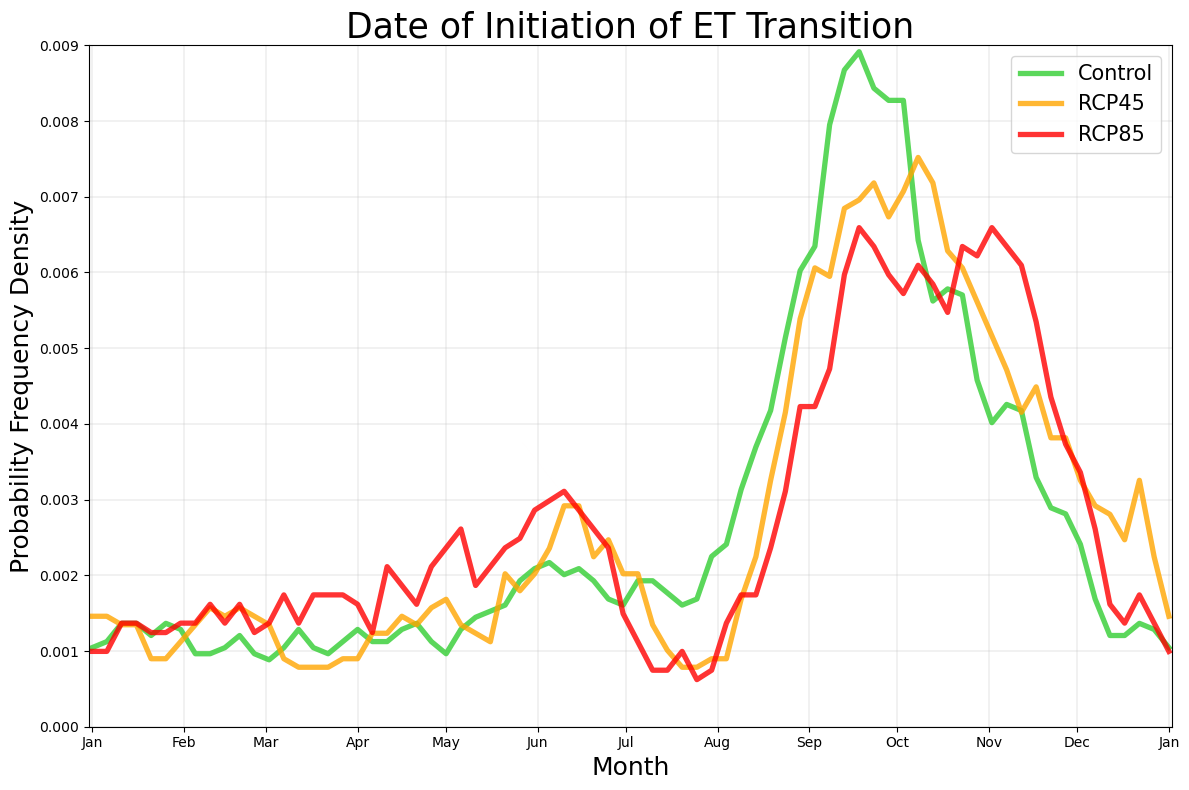

In [39]:
Fig = pyplot.figure(figsize=(12,8))
ET_Prob_Dist_Plot_Raw(Fig, Control_ET_Days, RCP45_ET_Days, RCP85_ET_Days, "Days")
pyplot.tight_layout()